In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

#### filtering data by city

In [2]:
city = "London"
dtf=pd.read_csv('data_stores.csv')
dtf=dtf[dtf["City"]==city][ ["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head()

total 216


id    City                                     Street Address      y      x
0   0  London                           265 Wharncliffe Rd North  42.99 -81.26
1   1  London                 1105 Wellington Rd., Store No. 122  42.93 -81.22
2   2  London                        631 Commissioners Road East  42.96 -81.23
3   3  London                            1442 Fanshawe Park Road  43.01 -81.34
4   4  London  580 Fanshawe Park Road East, Unit 1, White Oak...  43.03 -81.26

#### marking starting and delivery points

In [3]:
data = dtf.copy()
data["color"]=''
data.loc[data['id']==0 , 'color'] = 'red'
data.loc[data['id']!=0 , 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(3)

id    City                      Street Address      y      x  color
0   0  London            265 Wharncliffe Rd North  42.99 -81.26    red
1   1  London  1105 Wellington Rd., Store No. 122  42.93 -81.22  black
2   2  London         631 Commissioners Road East  42.96 -81.23  black

In [4]:
print("starting point:" , start)

starting point: [ 42.99 -81.26]


In [5]:
map = folium.Map(location=start, tiles= "cartodbpositron", zoom_start=12)
data.apply(lambda row: 
    folium.CircleMarker(
        location=[row["y"], row["x"]], 
        color=row["color"], fill = True, radius=5).add_to(map), axis=1)

map 

#### dealing with graph

C:\Users\mahee\AppData\Local\Programs\Python\Python311\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


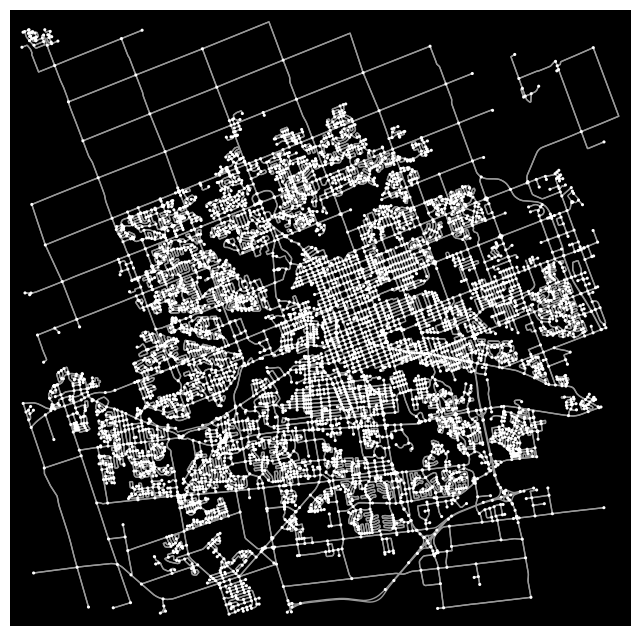

In [6]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5 , node_color="white", figsize=(16,8))

In [7]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')

C:\Users\mahee\AppData\Local\Temp\ipykernel_8736\1606664700.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
C:\Users\mahee\AppData\Local\Temp\ipykernel_8736\1606664700.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
C:\Users\mahee\AppData\Local\Temp\ipykernel_8736\1606664700.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (co

In [8]:
dtf.head()

id    City                                     Street Address      y  \
0   0  London                           265 Wharncliffe Rd North  42.99   
1   1  London                 1105 Wellington Rd., Store No. 122  42.93   
2   2  London                        631 Commissioners Road East  42.96   
3   3  London                            1442 Fanshawe Park Road  43.01   
4   4  London  580 Fanshawe Park Road East, Unit 1, White Oak...  43.03   

       x         node  
0 -81.26    289796441  
1 -81.22    324811692  
2 -81.23  11756886360  
3 -81.34    252974916  
4 -81.26    302754873

#### shortest path between nodes

In [9]:
def path(a , b):
    try:
        distance=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        distance=np.nan
    return distance

distance_matrix=np.asarray([[path(a,b)for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

289796441    324811692    11756886360  252974916    302754873    \
289796441            0.0        567.0        357.9        594.0        499.3   
324811692          592.1          0.0        211.0       1099.1        950.2   
11756886360        381.1        209.9          0.0        912.7        739.2   
252974916          592.3       1096.0        914.5          0.0        429.2   
302754873          499.2        950.2        740.3        430.1          0.0   

             305539079    347554420    4727288804   2600781784   1556562903   \
289796441          404.3        128.4        393.5        555.0        106.5   
324811692          712.5        458.8        874.4        736.8        494.6   
11756886360        578.7        247.8        663.4        550.4        283.6   
252974916          844.4        705.4        323.4        481.8        665.5   
302754873          467.1        574.0        108.0        893.0        514.4   

             1606842225   295523341    313507828    1609033105   312125272    \
289796441          514.3        435.2        234.7        203.8        566.3   
324811692          402.9        887.3        674.2        403.8        675.9   
11756886360        410.3        700.9        463.2        192.8        575.1   
252974916          725.3        355.7        500.7        768.0       1070.3   
302754873          865.8        765.6        349.6        569.1        693.0   

             260890490    311486306    3058247625   347336428    7271237232   
289796441          228.3        514.1        477.3       1037.2       1030.0  
324811692          790.5        120.0        982.4       1310.8        779.0  
11756886360        594.7        239.4        796.0       1194.9        911.1  
252974916          433.4       1024.9        174.5       1232.8        975.9  
302754873          396.5        972.4        313.4        855.5       1387.1

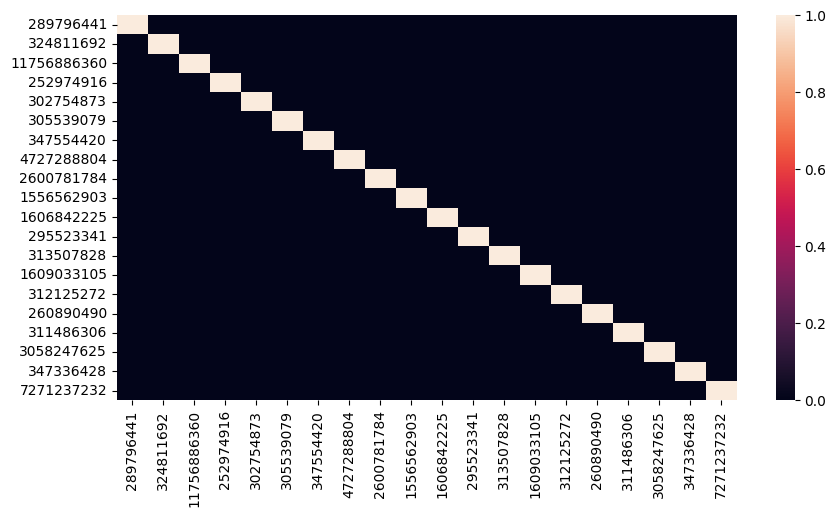

In [10]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x: 
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else 
          (0 if x!=0 else 1)) )
    
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , cbar=True, ax=ax)
plt.show()

In [11]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix

289796441    324811692    11756886360  252974916    302754873    \
289796441              0          567          358          594          499   
324811692            592            0          211         1099          950   
11756886360          381          210            0          913          739   
252974916            592         1096          914            0          429   
302754873            499          950          740          430            0   
305539079            404          641          582          845          469   
347554420            148          457          247          714          573   
4727288804           391          873          663          322          108   
2600781784           555          732          551          478          888   
1556562903           169          493          283          668          513   
1606842225           516          374          398          748          886   
295523341            434          887          705          356          765   
313507828            235          673          464          503          348   
1609033105           226          404          194          769          575   
312125272            589          608          559         1069          693   
260890490            228          786          586          433          396   
311486306            547          118          242         1027          971   
3058247625           476          980          799          174          313   
347336428           1034         1242         1194         1231          855   
7271237232          1030          781          912          977         1387   

             305539079    347554420    4727288804   2600781784   1556562903   \
289796441            404          128          394          555          106   
324811692            712          459          874          737          495   
11756886360          579          248          663          550          284   
252974916            844          705          323          482          666   
302754873            467          574          108          893          514   
305539079              0          436          523          895          377   
347554420            436            0          467          520           98   
4727288804           523          466            0          785          406   
2600781784           890          521          782            0          608   
1556562903           377           98          407          604            0   
1606842225           888          481          780          385          568   
295523341            767          507          659          188          540   
313507828            414          267          242          725          207   
1609033105           414           93          509          576          129   
312125272            310          492          747         1002          490   
260890490            561          355          290          570          334   
311486306            776          415          865          665          496   
3058247625           728          590          208          637          550   
347336428            688         1066          909         1525         1007   
7271237232          1389          996         1281          633         1083   

             1606842225   295523341    313507828    1609033105   312125272    \
289796441            514          435          235          204          566   
324811692            403          887          674          404          676   
11756886360          410          701          463          193          575   
252974916            725          356          501          768         1070   
302754873            866          766          350          569          693   
305539079            868          767          416          411          307   
347554420            479          515          267           93          492   
4727288804 

#### optimal route selection

In [12]:
drivers = 1 
lst_nodes= dtf["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)

start: 289796441 total locations to visit 19 drivers 1


In [13]:
manager= pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model=pywrapcp.RoutingModel(manager)

In [14]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

# search parameters
parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [15]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))
    
    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)
        
print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

route for driver:
[0, 6, 9, 13, 2, 1, 16, 10, 8, 11, 3, 17, 7, 4, 12, 15, 5, 14, 18, 19]
Total distance:6.7km
Nodes visited: 20


In [16]:
# which node to next node
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[289796441, 347554420, 1556562903, 1609033105, 11756886360, 324811692, 311486306, 1606842225, 2600781784, 295523341, 252974916, 3058247625, 4727288804, 302754873, 313507828, 260890490, 305539079, 312125272, 347336428, 7271237232]


In [17]:
# path between nodes
def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
    
map

C:\Users\mahee\AppData\Local\Temp\ipykernel_8736\309781449.py:20: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
C:\Users\mahee\AppData\Local\Temp\ipykernel_8736\309781449.py:20: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, rou

#### animation

In [18]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], [] 
        
        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])
            
        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), 
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))
        
    df=df.reset_index().rename(columns={"index":"id"})
    return df
            


In [19]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
# starting and ending point
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [20]:
df

id        start          end    start_x    start_y      end_x  \
0      0    289796441    293557419 -81.260399  42.989256 -81.258445   
1      1    293557419  12120514859 -81.258445  42.989189 -81.256653   
2      2  12120514859  12120514837 -81.256653  42.988821 -81.256557   
3      3  12120514837  12120514844 -81.256557  42.988542 -81.256466   
4      4  12120514844  12120514831 -81.256466  42.988375 -81.256294   
..   ...          ...          ...        ...        ...        ...   
990  990    300391230    266052927 -81.323562  42.904844 -81.332640   
991  991    266052927    300182337 -81.332640  42.909411 -81.337015   
992  992    300182337    254524172 -81.337015  42.912233 -81.342737   
993  993    254524172   1571564446 -81.342737  42.915418 -81.359672   
994  994   1571564446   7271237232 -81.359672  42.914564 -81.354891   

         end_y  length  travel_time  
0    42.989189     159           12  
1    42.988821     152           16  
2    42.988542      32            6  
3    42.988375      33            3  
4    42.988247      20            4  
..         ...     ...          ...  
990  42.909411     909           41  
991  42.912233     475           21  
992  42.915418     590           26  
993  42.914564    1390           62  
994  42.902331    1415          104  

[995 rows x 9 columns]

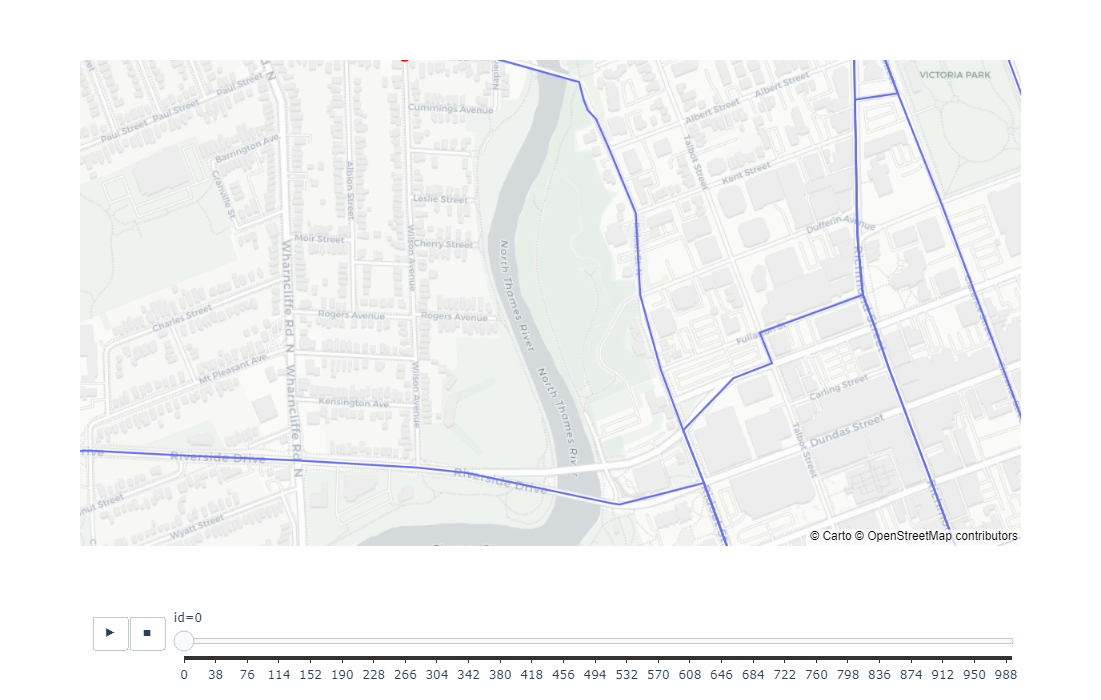

In [21]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig